<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Импортируем-библиотеки" data-toc-modified-id="Импортируем-библиотеки-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импортируем библиотеки</a></span></li><li><span><a href="#Откроем-и-исследуем-файл" data-toc-modified-id="Откроем-и-исследуем-файл-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Откроем и исследуем файл</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры.

Дополнительно измерим *AUC-ROC*, будем сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Импортируем библиотеки

In [1]:
!pip install imblearn

     |████████████████████████████████| 226 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 30.8 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionw
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import (roc_curve,
                             roc_auc_score,
                             f1_score,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             accuracy_score
                            )

import imblearn.over_sampling

### Откроем и исследуем файл

In [3]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

**Посмотрим общую информацию**:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Признаки:**

* *RowNumber* — индекс строки в данных
* *CustomerId* — уникальный идентификатор клиента
* *Surname* — фамилия
* *CreditScore* — кредитный рейтинг
* *Geography* — страна проживания
* *Gender* — пол
* *Age* — возраст
* *Tenure* — количество недвижимости у клиента
* *Balance* — баланс на счёте
* *NumOfProducts* — количество продуктов банка, используемых клиентом
* *HasCrCard* — наличие кредитной карты
* *IsActiveMember* — активность клиента
* *EstimatedSalary* — предполагаемая зарплата

**Целевой признак:**

* *Exited* — факт ухода клиента


Нам не понадобятся столбцы *RowNumber, CustomerId, Surname*

In [6]:
df = df.drop(columns = ['Surname', 'RowNumber', 'CustomerId'], axis = 1)

In [7]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Посмотрим на распределение значений из каждого столбца:**

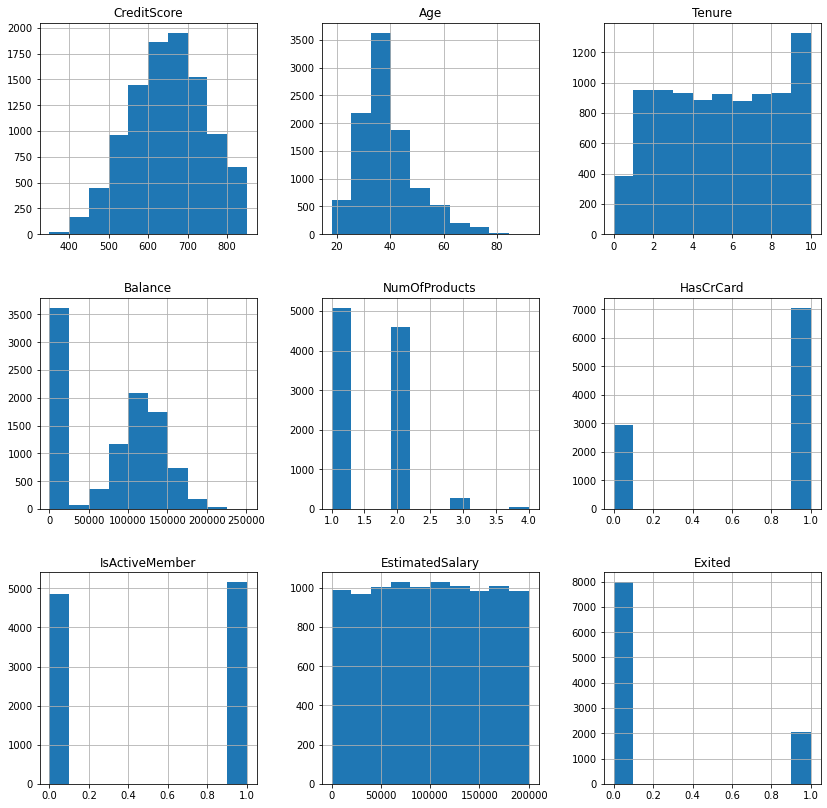

In [8]:
df.hist(figsize = (14,14));

**Количество пропусков:**

In [9]:
df.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [10]:
df.Tenure = df.Tenure.fillna(df.Tenure.median())
df.Tenure = df.Tenure.astype('int')

In [11]:
df.Tenure.value_counts()

5     1836
1      952
2      950
8      933
3      928
7      925
4      885
9      882
6      881
10     446
0      382
Name: Tenure, dtype: int64

In [12]:
df.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,-0.000060,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.012606,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.000060,-0.012606,1.000000,-0.007535,0.011409,0.025979,-0.030681,0.010049,-0.015989
Balance,0.006268,0.028308,-0.007535,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.011409,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.025979,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.030681,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.010049,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.015989,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


**Краткий вывод по первому пункту:**
* Открыли файл и изучили данные
* Посмотрели распределение значений в каждом столбце
* Выявлены пропуски в столбце *Tenure*. Значения в столбце от 0 до 10. 0 означает 0 лет клиент пользуется банком. Не будем заполнять пропуски
* Не обнаружилось сильно коррелирующих столбцов между собой. У всех корреляция примерно 0
* Исследованию не понадобятся столбцы: **RowNumber, CustomerId, Surname**, потому удалили их

## Исследование задачи

**В датафрейме есть столбцы с категориальными признаками. Преобразуем их методом OHE:**

In [13]:
df = pd.get_dummies(df, drop_first = True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [14]:
df_train, df_valid = train_test_split(df, test_size = 0.40, random_state = 12345)

df_valid, df_test = train_test_split(df_valid, test_size = 0.50, random_state = 12345)

In [15]:
features_train = df_train.drop(['Exited'], axis = 1)
target_train = df_train['Exited']

features_valid = df_valid.drop(['Exited'], axis = 1)
target_valid = df_valid['Exited']

features_test = df_test.drop(['Exited'], axis = 1)
target_test = df_test['Exited']

In [16]:
features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape

((6000, 11), (6000,), (2000, 11), (2000,), (2000, 11), (2000,))

**Данные успешно поделили**

In [17]:
df.Exited.value_counts(normalize = True).round(3)

0    0.796
1    0.204
Name: Exited, dtype: float64

**Видим, что факт ухода клиента зафиксирован в 20% случаев. Позже придется балансировать классы**

**Видим, что в столбцах Balance, CreditScore, EstimatedSalary разброс сильнее, чем в столбце Age. Так модель подумает, что значения столцов Balance, EstimatedSalary и CreditScore важнее, чем значения в Age. А это неправда. Стандартизируем:**

In [18]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Теперь приступим к обучению моделей. Использовать будем LogisticRegression и RandomForestClassifier**

In [19]:
def stats(predictions, target_valid, features_valid):
    print('Accuracy:', accuracy_score(predictions, target_valid))
    print('Recall:', recall_score(predictions, target_valid))
    print('Precision:',  precision_score(predictions, target_valid))
    print('F1:', f1_score(predictions, target_valid))
    
    probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
    print('AUC-ROC:', roc_auc_score(target_valid, probabilities_one_valid))

In [20]:
# Logistic Regression
model = LogisticRegression(random_state = 12345, class_weight = 'balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

stats(predictions, target_valid, features_valid)

Accuracy: 0.702
Recall: 0.3810160427807487
Precision: 0.6818181818181818
F1: 0.4888507718696398
AUC-ROC: 0.7636826378093262


In [21]:
# Подбор параметров для модели случайного леса
best_f1 = 0
best_estimators = 0
best_depth = 0
best_criterion = ''

for estimator in range(1,101,10):
    for depth in range(1,21):
        for criterion in ['gini', 'entropy']:
            model = RandomForestClassifier(
                                            n_estimators = estimator, 
                                            max_features = 'sqrt', 
                                            max_depth = depth,
                                            criterion = criterion,
                                           )
            model.fit(features_train, target_train)

            predictions = model.predict(features_valid)
            f1 = f1_score(target_valid, predictions)
            if f1 > best_f1:
                best_f1 = f1
                best_estimators = estimator
                best_depth=depth
                best_criterion = criterion
                                
params = {'Best Estimator' : best_estimators,
          'Best Depth' : best_depth,
          'Best Criterion' : best_criterion
         }
                        
print('Лучшая мера F1:', best_f1)
print('Лучшие параметры:', params)

Лучшая мера F1: 0.6026986506746627
Лучшие параметры: {'Best Estimator': 21, 'Best Depth': 11, 'Best Criterion': 'gini'}


**Невероятным усилием получили параметры лучшей модели случайного леса**

**Вывод**
* Разделили выборку на тренировочную, валидационную и тестовую. Модель обучилась на тестовой выборке, проверялась на валидационной, и будет предсказывать на тестовой выборке в 4 пункте
* Категориальные признаки трансформировали методом **OHE**
* Категоризировали значения в столбцах количественных признаков
* Посмотрели на значения целевого признака. Разброс положительных к отрицательным признакам - 20/80. В 3 пункте будем балансировать классы методом **upsampling** и **downsampling**
* Перебрали гиперпараметры модели случайного леса: Best Estimator: 61, Best Depth: 6, Best Criterion: entropy. Далее будем использовать их
* Модель **LogisticRegression** показала F1 равный 0.488, а модель **RandomForestClassifier** –– 0.63

## Борьба с дисбалансом

In [22]:
# Upsampling

def upsampling(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [23]:
features_upsampled_train, target_upsampled_train = upsampling(features_train, target_train, 4)

**Посмотрим, как модели покажут себя на выборках без дисбаланса:**

In [24]:
model = RandomForestClassifier(n_estimators = 61,
                               criterion = 'gini',
                               max_features = 'sqrt',
                               class_weight = 'balanced',
                               max_depth = 6)

model.fit(features_upsampled_train, target_upsampled_train)

predictions = model.predict(features_valid)
stats(predictions, target_valid, features_valid)

Accuracy: 0.798
Recall: 0.511864406779661
Precision: 0.722488038277512
F1: 0.5992063492063492
AUC-ROC: 0.8480195863754317


In [25]:
model = LogisticRegression()

model.fit(features_upsampled_train, target_upsampled_train)
predictions = model.predict(features_valid)
stats(predictions, target_valid, features_valid)

Accuracy: 0.702
Recall: 0.3810160427807487
Precision: 0.6818181818181818
F1: 0.4888507718696398
AUC-ROC: 0.7636176120107186


**Upsampling не помог: для модели логистической регрессии ничего не изменилось, а для случайного леса метрика F1 уменьшилась на 1%. Попробуем Downsampling**

In [26]:
# Downsampling
def downsampling(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [27]:
features_downsampled_train, target_downsampled_train = downsampling(features_train, target_train, 0.25)

In [28]:
model = LogisticRegression()

model.fit(features_downsampled_train, target_downsampled_train)
predictions = model.predict(features_valid)
stats(predictions, target_valid, features_valid)

Accuracy: 0.7005
Recall: 0.3781965006729475
Precision: 0.6722488038277512
F1: 0.48406546080964685
AUC-ROC: 0.7622278745939669


In [29]:
model = RandomForestClassifier(n_estimators = 61,
                               criterion = 'gini',
                               max_features = 'sqrt',
                               class_weight = 'balanced',
                               max_depth = 6)

model.fit(features_downsampled_train, target_downsampled_train)

predictions = model.predict(features_valid)
stats(predictions, target_valid, features_valid)

Accuracy: 0.779
Recall: 0.4815950920245399
Precision: 0.7511961722488039
F1: 0.5869158878504672
AUC-ROC: 0.8437218347558356


**Downsampling еще хуже сделал. F1 у случайного леса понизилась еще на 1%, а у логистической регрессии – на 0.4%**

**Вывод**
* Обучили две модели: **Logistic Regression** и **RandomForestClassifier**
* Логистическая регрессия показала F1 меру 48%, а случайный лес показал 61% без устранения дисбаланса
* В результате апсемплинга логистическая регрессия показала F1 меру 48.8% (без изменений), а случайный лес показал 60% (на 1 процент меньше) –- апсемплинг не помог
* В результате даунсемплинга логистическая регрессия показала F1 меру 48.4% (на 0.4% меньше чем в апсемплинге), а случайный лес показал 59% (еще на 1% меньше чем в апсемплинге)
* **RandomForestClassifier** лучшая модель, ее будем использовать на тестовой выборке

## Тестирование модели

In [30]:
model = RandomForestClassifier(n_estimators = 61,
                               criterion = 'gini',
                               max_features = 'sqrt',
                               class_weight = 'balanced',
                               max_depth = 6)

model.fit(features_train, target_train)

predictions = model.predict(features_test)
stats(predictions, target_test, features_test)

Accuracy: 0.798
Recall: 0.5164075993091537
Precision: 0.706855791962175
F1: 0.5968063872255489
AUC-ROC: 0.8451739020284196


**Вывод**
* Открыли и изучили данные
* Трансформировали категориальные признаки методом OHE, стандартизировали количественные признаки
* Выявили дисбаланс классов: 1:4
* Проверили Логистическую регрессию и случайный лес без увеличения и уменьшения выборки. Лучшей моделью оказался случайный лес. Его F-мера составила 61%.
* После апсемплинга показатели обеих моделей ухудшились, точно как и после даунсемплинге
* Решили использовать данные без апсемсплинга и даунсемплинга, на тестовой выборке модель случайного леса показала F1 меру 60,1%, AUC-ROC – 85% 